In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

# plot styles/formatting
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import Colorbar # different way to handle colorbar

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# extras
%matplotlib inline
import wrf

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures
path_wrf = '/home/sbarc/students/wrf4211/WPS_nash/'


In [3]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)


In [11]:
## points of landslides (chosen in fig10_wvf_climatology-analysis.ipynb)
pt1 = [72.6625, 34.8733]
pt2 = [74.0225, 34.0876]
ptlst = [pt1, pt2]
# Line1 = [latmin, lonmin, latmax, lonmax] 

line1 = [32., pt1[0], 35., pt1[0]]
line2 = [32., pt2[0], 35., pt2[0]]

newline = [line1, line2]

In [5]:
arname = 'feb2010'
# import configuration file for case study choice
yaml_doc = '../data/config_files/ar_casestudy.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ar_dict = config[arname]

year = ar_dict['year']
month = ar_dict['month']
start_date = ar_dict['start_date']
end_date = add_days_to_date(ar_dict['end_date'], 1)
print(start_date, end_date)

# Select lat/lon grid
lonmin = 60.2
lonmax = 100
latmin = 16
latmax = 50

2010-02-05 2010-02-09


In [6]:
wrf_filenames = [ar_dict['wrf_files2'][0], ar_dict['wrf_files'][0]] # d01, d02
resolutions = [20, 6.7]

ds_lst = []
for i, f in enumerate(wrf_filenames):
    wrfin = nc.Dataset(f)
    data = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height
    
    lats = data.XLAT.isel(west_east=0).values
    lons = data.XLONG.isel(south_north=0).values

    # put into new ds
    var_dict = {'hgt': (['lat', 'lon'], data.values)}


    tmp = xr.Dataset(var_dict,
                    coords={'lat': (['lat'], lats),
                            'lon': (['lon'], lons)})

    ds_lst.append(tmp)

ds_lst

[<xarray.Dataset>
 Dimensions:  (lat: 249, lon: 259)
 Coordinates:
   * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
   * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
 Data variables:
     hgt      (lat, lon) float32 0.0 0.0 0.0 ... 1.466e+03 1.447e+03 1.366e+03,
 <xarray.Dataset>
 Dimensions:  (lat: 312, lon: 447)
 Coordinates:
   * lat      (lat) float32 22.05 22.11 22.18 22.24 ... 40.17 40.23 40.28 40.33
   * lon      (lon) float32 68.24 68.31 68.37 68.44 ... 98.91 98.98 99.05 99.12
 Data variables:
     hgt      (lat, lon) float32 0.0 0.0 0.0 ... 1.304e+03 1.294e+03 1.282e+03]

In [7]:
geogrid_bnds = []
for i, ds in enumerate(ds_lst):
    lonmin = ds.lon.min().values.tolist()
    lonmax = ds.lon.max().values.tolist()
    latmin = ds.lat.min().values.tolist()
    latmax = ds.lat.max().values.tolist()
    bnds = [lonmin, lonmax, latmin, latmax]
    geogrid_bnds.append(bnds)
    
print(geogrid_bnds)
d01 = geogrid_bnds[0]
d02 = geogrid_bnds[1]
ndom = len(geogrid_bnds)

[[60.203857421875, 113.796142578125, 16.42810821533203, 56.15325927734375], [68.23577880859375, 99.11711120605469, 22.04749298095703, 40.33241271972656]]


In [8]:
# subregion info for ar type precip anomalies
ext1 = [69, 74, 37, 40] # Northwestern precip anomalies
ext2 = [71, 79, 32, 37] # Western precip anomalies
ext3 = [90, 99, 24, 30] # Eastern precip anomalies
domains = [ext1, ext2, ext3]

# # subregion info for karakoram anomaly analysis
# ext1 = [70, 80, 34, 38] # Karakoram region
# ext2 = [78, 88, 26, 30] # Central Himalaya region
# domains = [ext1, ext2]

# domain extent info 
# [xmin, ymin]
sr_xy2 = []
sr_width2 = []
sr_height2 = []

for i, d in enumerate(domains):
    sr_xy2.append([d[0], d[2]])
    sr_width2.append((d[1] - d[0]))
    sr_height2.append((d[3]- d[2]))

print(sr_xy2)
print(sr_width2)
print(sr_height2)

[[69, 37], [71, 32], [90, 24]]
[5, 8, 9]
[3, 5, 6]


### Plot domains

In [12]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
j = 10
dx = np.arange(round(d01[0]),round(d01[1]+j),j)
dy = np.arange(round(d01[2]),round(d01[3]+j),j)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []
dom_lbl = []
lbl_loc = []

for i, (d, res) in enumerate(zip(geogrid_bnds, resolutions)):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))
    dom_lbl.append('({2}) D0{0} ({1} km)'.format(i+1, res, letter_lst[i]))
    lbl_loc.append([d[0]+1, d[2]+1])
    
print(sr_xy)
print(sr_width)
print(sr_height)
print(dom_lbl)

# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)

# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=-250., vcenter=1, vmax=6000)

[[60.203857421875, 16.42810821533203], [68.23577880859375, 22.04749298095703]]
[53.59228515625, 30.881332397460938]
[39.72515106201172, 18.28491973876953]
['(a) D01 (20 km)', '(b) D02 (6.7 km)']


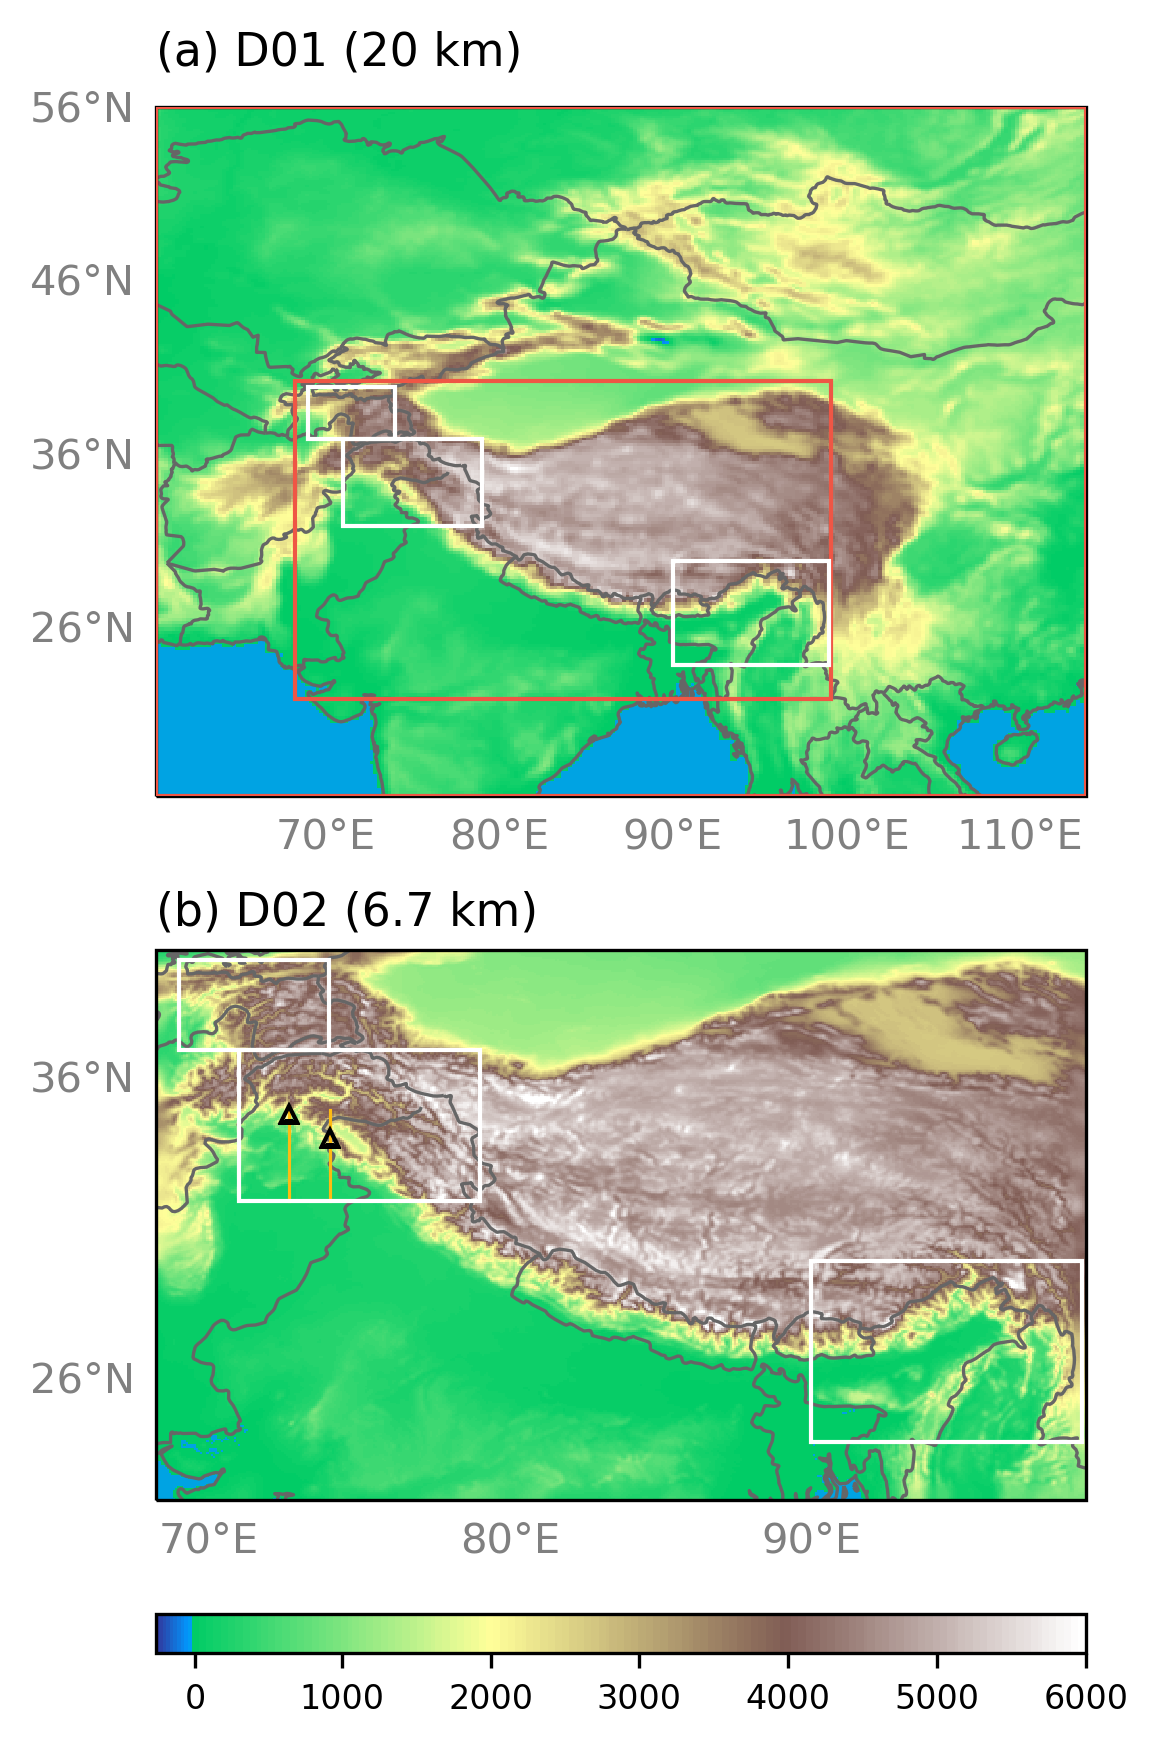

In [13]:
# Create figure
fig = plt.figure(figsize=(4, 7))
fig.dpi = 300
fname = path_to_figs + 'wrf_geogrid_norris'
fmt = 'png'

nrows = ndom+1
ncols = 1

# Set up Axes Grid
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1]*(nrows-1) + [0.05], width_ratios = [1], hspace=0.01)
## use gs[rows index, columns index] to access grids

for k in range(nrows-1):
    ax = fig.add_subplot(gs[k, 0], projection=mapcrs)
    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=10, 
                   length=4, 
                   pad=2, 
                   color='black')
    
    ax = draw_basemap(ax, extent=geogrid_bnds[k], xticks=dx, yticks=dy)

#     cf = ax.pcolormesh(lons, lats, topo, transform=datacrs, cmap=cmap, cbar_kwargs=dict(pad=0.01, aspect=30))
    ds = ds_lst[k]
    lats = ds.lat.values
    lons = ds.lon.values
    topo = ds.hgt.values
    pcm = ax.pcolormesh(lons, lats, topo, rasterized=True, norm=divnorm,
                        cmap=terrain_map, shading='auto')

    if k == 0:
        # add inner domain extents
        add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                            height=sr_height, ecolor='#EF5645', datacrs=datacrs)
        
        # add subregions
        add_subregion_boxes(ax=ax, subregion_xy=sr_xy2, width=sr_width2, 
                            height=sr_height2, ecolor='white', datacrs=datacrs)
        
        # # add zonal lines
        # line_lst = [Line2, Line3]
        # for i, line in enumerate(line_lst):
        #     ax.plot([line[1], line[3]],
        #                 [line[0], line[2]], color='#EF5645',
        #                 transform=datacrs, linewidth=0.75, zorder=3)


        # if arname == 'feb2010':
        #     # add landslide points
        #     landslide_pts = [[73.7526, 34.0049], [75.8011, 33.1595], [72.6625, 34.8733]]
        #     for i, pt in enumerate(landslide_pts):
        #         ax.plot(pt[0], pt[1], alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
    
    if k == 1:
        # add subregions
        add_subregion_boxes(ax=ax, subregion_xy=sr_xy2, width=sr_width2, 
                            height=sr_height2, ecolor='white', datacrs=datacrs)
        
        # add meridional lines
        for i, line in enumerate(newline):
            ax.plot([line[1], line[3]],
                        [line[0], line[2]], color='#FEBC11',
                        transform=datacrs, linewidth=0.75, zorder=3)


        # add intersection points
        for i, pt in enumerate(ptlst):
            ax.plot(pt[0], pt[1], marker='^', ms=4, mec='k', mfc="None", transform=mapcrs, zorder=101)
    

    # add domain labels
    ax.set_title(dom_lbl[k], loc='left', fontsize=11)
#     for i in range(len(dom_lbl)):
#         ax.annotate(dom_lbl[i], lbl_loc[i], xycoords='data', fontsize=8.,
#                     backgroundcolor='white')




# Colorbar (single)
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax=cbax, mappable=pcm, orientation='horizontal', ticklocation='bottom')
cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()